## Задание

На проекте, где пользователь может отправить лайк другому пользователю, для увеличения количества лайков провели тест на замену сердца на галочку. При нажатии на крестик пользователю предлагается следующий пользователь. Тестовый вариант внедрили на пользователях с нечетным sender_id 24 марта в 16:00, на четных пользователях оставили базовый вариант.

## Вопрос
1. Нужно ли внедрить нововведение для всех или отклонить его?
2. Подкрепите выводы графиками. 
3. Также прикрепите ваши расчеты.

### Данные в файле Test_AB.rar
|field|description|
|---|---|
| sender_id | уникальный идентификатор отправителя|
|platform_id|id платформы, 6 - декстоп, 7 - мобильная версия|
|time_stamp|Дата и время отправки|
|gender|Гендер отправителя|
|reg_date!|Дата регистрации пользователя|



In [1]:
import datetime
import pandas as pd
from IPython.core.display import HTML 
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('Test_4.csv',sep=';',parse_dates=['time_stamp','reg_date'])

test_start_date = '2017-03-24 16:00:00'
test_users = data[data.time_stamp >= test_start_date]

test_users.gender.unique()
data.platform_id.unique()

# Count of records without gender
test_users[test_users.gender == ' ' ].shape[0]

# Sender IDs without gender
test_users[test_users.gender == ' ' ].sender_id.unique()

# Remove 23 records without gender
test_users = test_users[test_users.gender != ' ']

In [3]:
# Add test version column
test_users['test_version'] = test_users['sender_id'].apply(lambda x: False if x % 2 == 0 else True)

# Add Date when like was send
test_users['send_date'] = test_users['time_stamp'].apply(lambda x: x.date())

# Add Hour when like was send
test_users['send_hour'] = test_users['time_stamp'].apply(lambda x: datetime.time(x.hour))

### Количество лайков в час 
Проанализируем динамику отправки лайков в тестовой и базовой версии 

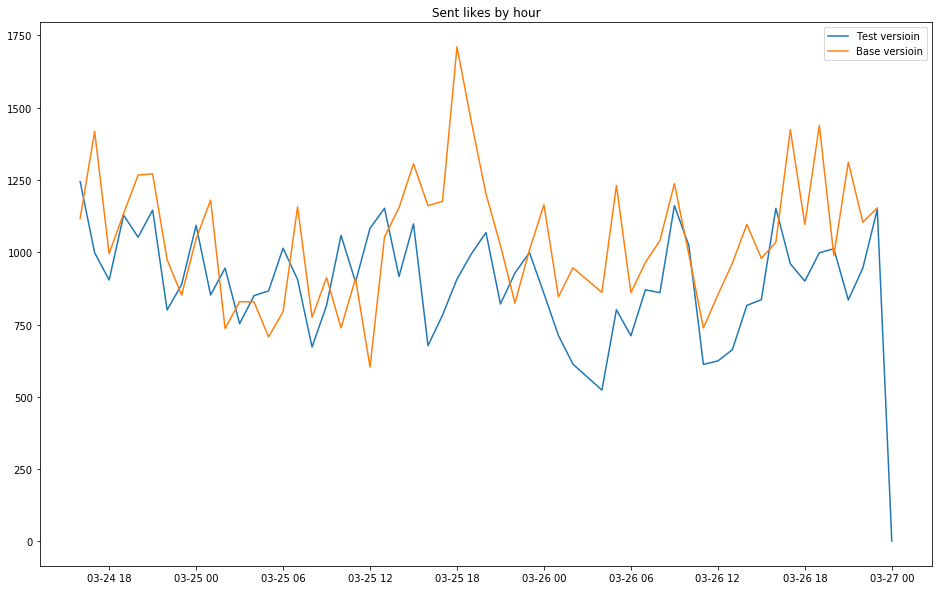

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

send_by_date = test_users.groupby(['send_date','send_hour','test_version']).count().reset_index()

#Combine send date and hour and add it to new column send_date_hour
send_by_date['send_date_hour'] = send_by_date.apply(lambda x: pd.datetime.combine(x['send_date'],x['send_hour']),1)

# Send likes by date and hour
send_by_date = send_by_date.loc[:,['send_date_hour','test_version','sender_id']].sort_values(by='send_date_hour')

# Plot count of sent likes per hour of Base and Test versions
fig, ax = plt.subplots(1, 1, figsize=(16,10))
ax.plot(send_by_date[send_by_date['test_version']==True].set_index('send_date_hour')['sender_id'], label='Test versioin')
ax.plot(send_by_date[send_by_date['test_version']==False].set_index('send_date_hour')['sender_id'], label='Base versioin')

ax.set_title('Sent likes by hour')
ax.legend(loc='upper right')


Роста количества лайков в тестовой версии визуально не видно.  
Начиная с 25-го марта количество лайков в тестовой версии меньше чем в базовой.

### Количество регистраций
Проанализируем динамику регистраций новых пользователей

Text(0.5, 0.04, 'Registration date')

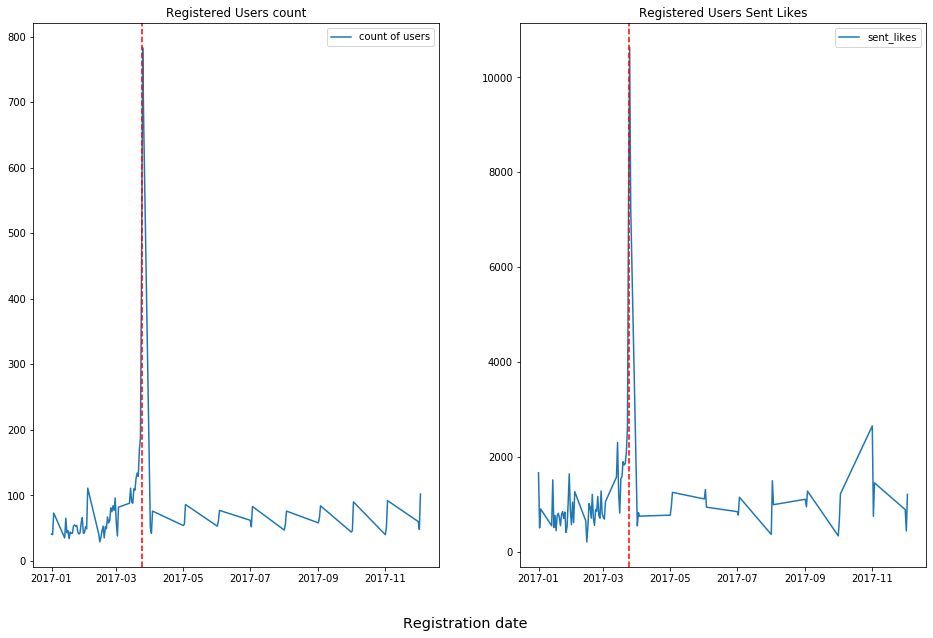

In [5]:
# Group by registration date and sender id
users_by_reg_date = test_users.groupby(['reg_date','sender_id'])['time_stamp'].count().reset_index(name='sent_likes')

# Group by registration date. Count users and likes sent by those users
users_and_likes = users_by_reg_date.groupby(['reg_date']).agg({'sender_id':'count', 'sent_likes': 'sum'}).reset_index().rename(columns={'sender_id':'count_of_users'})

# Plot count of registered users by date and sum of likes sent by those users
fig, ax = plt.subplots(1, 2, figsize=(16,10))

ax[0].plot(users_and_likes.set_index('reg_date').iloc[:,:1].sort_values(by='reg_date'), label='count of users')
ax[0].axvline(test_start_date, color='r', ls='--')
ax[0].set_title('Registered Users count')
ax[0].legend(loc='upper right')

ax[1].plot(users_and_likes.set_index('reg_date').iloc[:,1:2].sort_values(by='reg_date'), label='sent_likes')
ax[1].axvline(test_start_date, color='r', ls='--')
ax[1].set_title('Registered Users Sent Likes')
ax[1].legend(loc='upper right')

fig.text(0.5, 0.04, 'Registration date', ha='center', fontsize='x-large')


Анализируя график регистраций мы видим, что в период с 17 по 26 марта в приложение пришло больше чем две с половиной тысячи новых пользователей 

In [6]:
# Count of users registered in from 17 till 27 of March
regs_in_march = users_and_likes[(users_and_likes['reg_date']>='2017-03-17') & (users_and_likes['reg_date']<='2017-03-27')]

# Add totals
regs_in_march = regs_in_march.append(regs_in_march.sum(numeric_only=True), ignore_index=True)

display(HTML(regs_in_march.to_html()))

,reg_date,count_of_users,sent_likes
0,2017-03-17,110.0,1539.0
1,2017-03-18,108.0,1576.0
2,2017-03-19,126.0,1896.0
3,2017-03-20,134.0,1828.0
4,2017-03-21,129.0,1858.0
5,2017-03-22,169.0,2086.0
6,2017-03-23,188.0,2599.0
7,2017-03-24,444.0,7263.0
8,2017-03-25,783.0,10627.0
9,2017-03-26,663.0,7244.0


Для максимально объективного сравнения двух версий приложения необходимо убедиться, что между полученными группами пользователей разница определяется только изменениями, которые были сделаны в продукте. 

За основу возьмем пользователей которые пришли в период с 17 по 26 марта, так как степень знакомства с продуктом у этих пользователей должна быть схожей.  
Разделим пользователей на 8 групп исходя из **пола**, **платформы** и **версии приложения**:
- женщины; десктоп; test
- женщины; десктоп; base
- женщины; мобайл; test
- женщины; мобайл; base
- мужщины; десктоп; test
- мужщины; десктоп; base
- мужщины; мобайл; test
- мужщины; мобайл; base

### Статистические показатели 
Посчитаем основные статистические показатели каждой из групп

In [7]:
# Filter only users registered from 17 till 27 of March
test_users = test_users[(test_users['reg_date']>='2017-03-17') & (test_users['reg_date']<='2017-03-27')]

# Group by platform, gender, test version and generate descriptive statistics 
grouped_by_sid = test_users.groupby(['sender_id','send_date','test_version','gender','platform_id','reg_date'])['time_stamp'].count().reset_index(name="count")
stats = grouped_by_sid.groupby(['platform_id','gender','test_version'])['count'].describe().reset_index()

# Add sum of likes by each group
sum_of_likes = test_users.groupby(['platform_id','gender','test_version'])['sender_id'].count().reset_index(name="sum")

# Merge statistics with sum of likes
stats_final = pd.merge(sum_of_likes,stats, on=['platform_id','gender','test_version'] )
display(HTML(stats_final.to_html()))


,platform_id,gender,test_version,sum,count,mean,std,min,25%,50%,75%,max
0,6,f,False,1908,224.0,8.517857,12.929600,1.0,2.00,4.0,9.25,106.0
1,6,f,True,2344,201.0,11.661692,19.253181,1.0,2.00,4.0,14.00,143.0
2,6,m,False,7719,585.0,13.194872,15.598987,1.0,2.00,7.0,19.00,142.0
3,6,m,True,7692,568.0,13.542254,17.367030,1.0,1.75,7.0,19.25,143.0
4,7,f,False,1878,299.0,6.280936,9.474870,1.0,1.00,3.0,5.00,90.0
5,7,f,True,1595,255.0,6.254902,7.489739,1.0,1.00,5.0,7.00,46.0
6,7,m,False,8437,751.0,11.234354,24.730730,1.0,1.00,4.0,12.00,321.0
7,7,m,True,6943,644.0,10.781056,16.298161,1.0,1.00,4.0,13.00,241.0


Среднее количество отправленных лайков в день и общее количество отправленных лайков выросло у групп:
-  женщины; десктоп;
-  мужщины; десктоп;

У всех остальных групп среднее количество отправленных лайков в день и общее количество отправленных лайков упало в тестовой версии по сравнению с базовой.


In [8]:
# Comparison groups 

women_test_desktop = grouped_by_sid[(grouped_by_sid['gender']=='f') & (grouped_by_sid['test_version']==True) & (grouped_by_sid['platform_id'] == 6)]
women_base_desktop = grouped_by_sid[(grouped_by_sid['gender']=='f') & (grouped_by_sid['test_version']==False) & (grouped_by_sid['platform_id'] == 6)]

women_test_mobile = grouped_by_sid[(grouped_by_sid['gender']=='f') & (grouped_by_sid['test_version']==True) & (grouped_by_sid['platform_id'] == 7)]
women_base_mobile = grouped_by_sid[(grouped_by_sid['gender']=='f') & (grouped_by_sid['test_version']==False) & (grouped_by_sid['platform_id'] == 7)]

men_test_desktop = grouped_by_sid[(grouped_by_sid['gender']=='m') & (grouped_by_sid['test_version']==True) & (grouped_by_sid['platform_id'] == 6)]
men_base_desktop = grouped_by_sid[(grouped_by_sid['gender']=='m') & (grouped_by_sid['test_version']==False) & (grouped_by_sid['platform_id'] == 6)]

men_test_mobile = grouped_by_sid[(grouped_by_sid['gender']=='m') & (grouped_by_sid['test_version']==True) & (grouped_by_sid['platform_id'] == 7)]
men_base_mobile = grouped_by_sid[(grouped_by_sid['gender']=='m') & (grouped_by_sid['test_version']==False) & (grouped_by_sid['platform_id'] == 7)]


## Тип распределения 
Для того чтобы выбрать метод проверки гипотезы (проверка статистической значимости) определим тип распределения для каждой из групп.

Text(0.04, 0.5, 'Frequency')

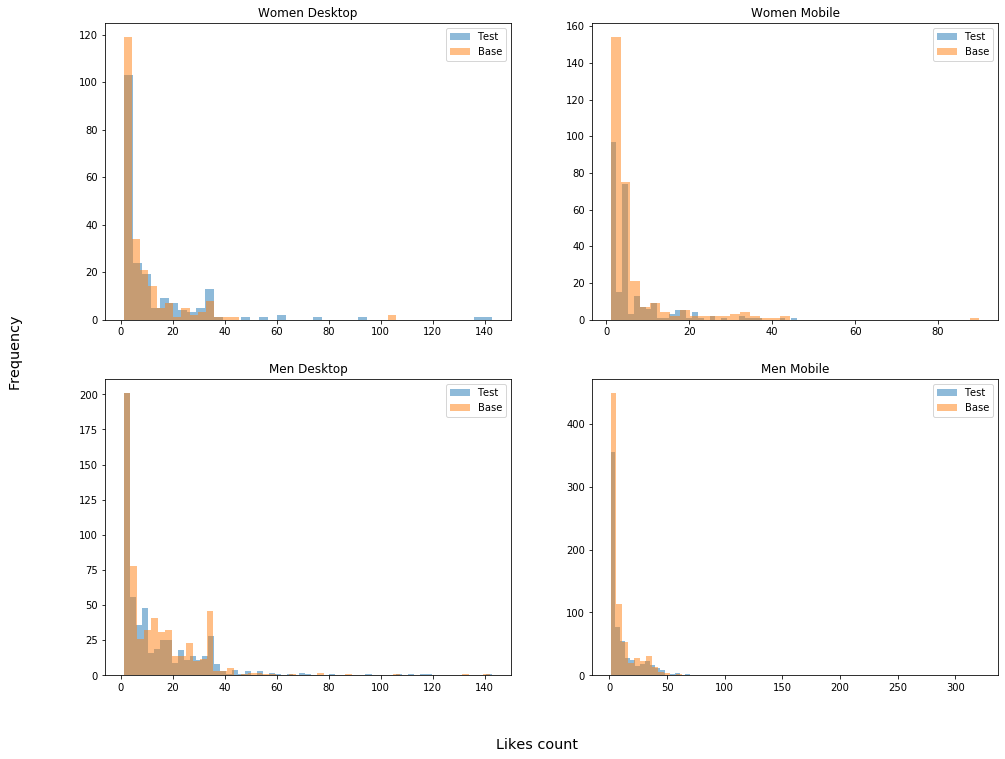

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))
ax = ax.ravel() 

ax[0].hist(women_test_desktop['count'], bins=len(women_test_desktop['count'].unique()), alpha=0.5, label='Test')
ax[0].hist(women_base_desktop['count'], bins=len(women_base_desktop['count'].unique()), alpha=0.5, label='Base')
ax[0].set_title('Women Desktop')
ax[0].legend(loc='upper right')

ax[1].hist(women_test_mobile['count'], bins=len(women_test_mobile['count'].unique()), alpha=0.5, label='Test')
ax[1].hist(women_base_mobile['count'], bins=len(women_base_mobile['count'].unique()), alpha=0.5, label='Base')
ax[1].set_title('Women Mobile')
ax[1].legend(loc='upper right')

ax[2].hist(men_test_desktop['count'], bins=len(men_test_desktop['count'].unique()), alpha=0.5, label='Test')
ax[2].hist(men_base_desktop['count'], bins=len(men_base_desktop['count'].unique()), alpha=0.5, label='Base')
ax[2].set_title('Men Desktop')
ax[2].legend(loc='upper right')

ax[3].hist(men_test_mobile['count'], bins=len(men_test_mobile['count'].unique()), alpha=0.5, label='Test')
ax[3].hist(men_base_mobile['count'], bins=len(men_base_mobile['count'].unique()), alpha=0.5, label='Base')
ax[3].set_title('Men Mobile')
ax[3].legend(loc='upper right')

fig.text(0.5, 0.04, 'Likes count', ha='center', fontsize='x-large')
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize='x-large')

Анализируя гистограмы каждой из тестовых групп можно сделать вывод, что количество лайков распределено неравномерно в каждой из тестовых групп. 
Исходя из этого, рекомендоваными методами проверки нулевой гипотезы будут непараметрические статистические тесты, например - Mann Whitney U Test

Но, так как размер выборки каждой группы больше 200, статистическую значимость [можно проверять используя t-критерием Стьюдента](https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/)



### Проверка гипотезы (статистической значимости)
Для каждой из групп проверим нулевую гипотезу используя t-test и Mann Whitney U Test

**H0 (нулевая гипотеза)** - изменение сердца на галочку не повлияло на количество отправленных лайков  
**H1 (альтернативная гипотеза)** - изменение сердца на галочку повлияло на количество отправленных лайков


In [10]:
from scipy import stats

test_results = pd.DataFrame( columns=['group','t','p_ttest','statistic','p_mannwhitneyu'])

test_results.loc[0,'group'] = 'women desktop'
test_results.loc[0,['t','p_ttest']] = stats.ttest_ind(women_test_desktop['count'],women_base_desktop['count'])
test_results.loc[0,['statistic','p_mannwhitneyu']] = stats.mannwhitneyu(women_test_desktop['count'],women_base_desktop['count'])

test_results.loc[1,'group'] = 'women mobile'
test_results.loc[1,['t','p_ttest']] = stats.ttest_ind(women_test_mobile['count'],women_base_mobile['count'])
test_results.loc[1,['statistic','p_mannwhitneyu']] = stats.mannwhitneyu(women_test_mobile['count'],women_base_mobile['count'])

test_results.loc[2,'group'] = 'men desktop'
test_results.loc[2,['t','p_ttest']] = stats.ttest_ind(men_test_desktop['count'],men_base_desktop['count'])
test_results.loc[2,['statistic','p_mannwhitneyu']] = stats.mannwhitneyu(men_test_desktop['count'],men_base_desktop['count'])

test_results.loc[3,'group'] = 'men mobile'
test_results.loc[3,['t','p_ttest']] = stats.ttest_ind(men_test_mobile['count'],men_base_mobile['count'])
test_results.loc[3,['statistic','p_mannwhitneyu']] = stats.mannwhitneyu(men_test_mobile['count'],men_base_mobile['count'])

def color_cell(cell):
    return 'color: ' + ('red' if cell < 0.05 else 'black')

html = test_results.style.applymap(color_cell, subset=['t','p_ttest','p_mannwhitneyu']).render()

display(HTML(html))

,group,t,p_ttest,statistic,p_mannwhitneyu
0,women desktop,1.9938,0.0468154,21618,0.237979
1,women mobile,-0.0354383,0.971743,35422.5,0.0715551
2,men desktop,0.357542,0.720751,163486,0.318117
3,men mobile,-0.397041,0.691398,237530,0.281684


### Выводы

T-критерий Стьюдента показал статистически значимую увеличение количества отправленых лайков у женщин использующих десктоп. 
Разница в количестве отправленных лайков, между Базовой и Тестовой версией, у других пользователей не является статистически значимой. 

Mann Whitney U Test не выявил разницы между Базовой и Тестовой версией приложения ни у одной из групп.

#### Рекомендации
Нововведение стоит отклонить.  
Учитывая, что женщины использующие десктоп - самая маленькая группа, результат t-критерия Стьюдента не стоит считать окончательным. 
Можно повторно провести тестирования только для этой группы пользователей, для принятия окончательного решения 
